In [1]:
%load_ext autoreload
%autoreload 2

In [163]:
import re
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from prettytable import PrettyTable
from glob import glob

from utils import draw_trajectories, get_metric, plot_metric

# Checks

## Is the evaluation scenario exactly the same for all agents? **YES**

<Axes: xlabel='Timesteps', ylabel='Wind cos'>

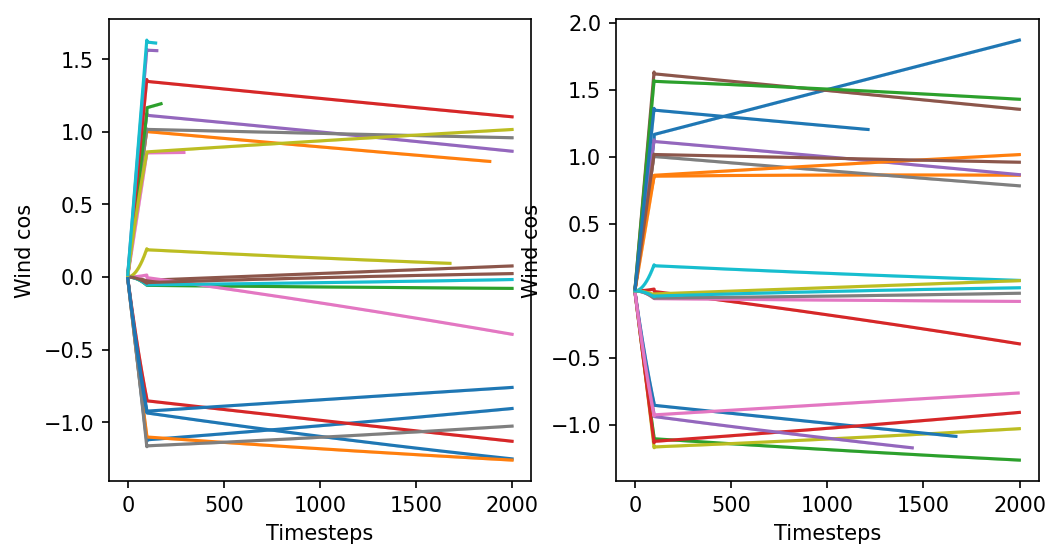

In [168]:
fig, axs = plt.subplots(1, 2, figsize=(2*4, 4), dpi=150)
plot_metric(
    glob('../runs/08-28-max-wind-v1-scenario-1/eval-*/0/*.csv'),
    metric='obs/wind/0',
    y_label='Wind cos',
    ax=axs[0], hide_legend=True)
plot_metric(
    glob('../runs/08-28-max-wind-v2-scenario-1/eval-*/0/*.csv'),
    'obs/wind/0',
    y_label='Wind cos',
    ax=axs[1], hide_legend=True)

<Axes: xlabel='Timesteps', ylabel='Wind sin'>

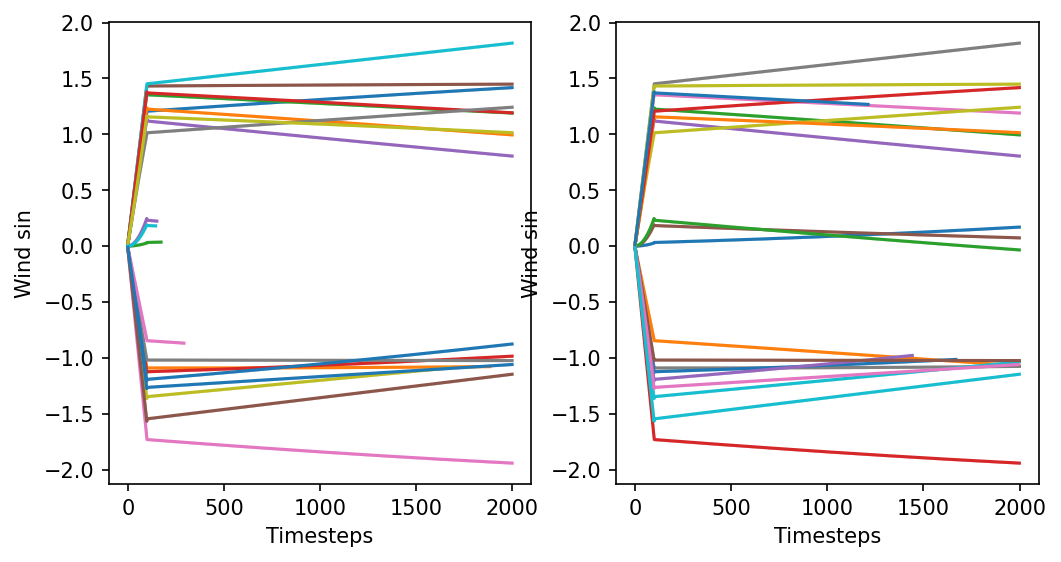

In [167]:
fig, axs = plt.subplots(1, 2, figsize=(2*4, 4), dpi=150)
plot_metric(
    glob('../runs/08-28-max-wind-v1-scenario-1/eval-*/0/*.csv'),
    metric='obs/wind/1',
    y_label='Wind sin',
    ax=axs[0], hide_legend=True)
plot_metric(
    glob('../runs/08-28-max-wind-v2-scenario-1/eval-*/0/*.csv'),
    'obs/wind/1',
    y_label='Wind sin',
    ax=axs[1], hide_legend=True)

<Axes: xlabel='Timesteps', ylabel='Theta Wind'>

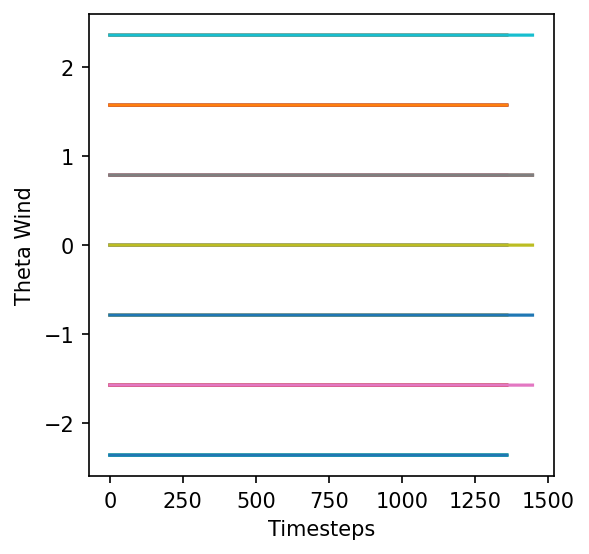

In [178]:
import numpy as np
plot_metric(
    glob('../runs/08-29-test-8/eval-*/0/*.csv'),
    metric=lambda _, df: (np.arange(len(df)), np.arctan2(df['obs/wind/1'].values, df['obs/wind/0'].values)),
    y_label='Theta Wind',
    hide_legend=True)

# Best hyperparameters selection

based on theses results, we will use the following hyperparameters for the final evaluation:

```bash
python3 scripts/sb3_train_and_eval.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=8 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10"
```

In [154]:
def get_k_best_hyperparams(k, majority_cols=['clip_range', 'batch_size', 'n_steps', 'n_epochs', 'gamma', 'gae_lambda', 'max_grad_norm']):
    study = optuna.load_study(
        study_name='sb3-tuning-coktailjet-7-trials', storage='sqlite:///../optuna.db')
    df = study.trials_dataframe(multi_index=True)
    df.sort_values(('value'), inplace=True, ascending=False)
    df = df['params'].head(k)
    print(f'Best hyperparameters (k={k}):')
    for col, col_type in zip(df.columns, df.dtypes):
        if col_type == object or col_type == bool or col_type == str or col in majority_cols:
            print(f'\t{col}:\t{df[col].mode().item()}')
        else:
            print(f'\t{col}:\t{df[col].mean():.2e}±{df[col].std():.2e} (median={df[col].median():.2e})')

get_k_best_hyperparams(5)
print()
get_k_best_hyperparams(10)
print()
get_k_best_hyperparams(20)
print()
get_k_best_hyperparams(50)

Best hyperparameters (k=5):
	activation_fn:	relu
	batch_size:	8
	clip_range:	0.2
	ent_coef:	8.36e-04±1.80e-03 (median=3.92e-06)
	gae_lambda:	0.95
	gamma:	0.999
	learning_rate:	7.22e-05±6.76e-05 (median=3.59e-05)
	max_grad_norm:	0.9
	n_epochs:	10
	n_steps:	1024
	net_arch:	medium
	vf_coef:	2.88e-01±1.89e-01 (median=2.03e-01)

Best hyperparameters (k=10):
	activation_fn:	relu
	batch_size:	8
	clip_range:	0.2
	ent_coef:	4.20e-04±1.28e-03 (median=3.72e-06)
	gae_lambda:	0.9
	gamma:	0.999
	learning_rate:	5.76e-05±5.57e-05 (median=2.75e-05)
	max_grad_norm:	0.6
	n_epochs:	10
	n_steps:	1024
	net_arch:	medium
	vf_coef:	2.37e-01±1.38e-01 (median=1.95e-01)

Best hyperparameters (k=20):
	activation_fn:	relu
	batch_size:	8
	clip_range:	0.2
	ent_coef:	2.83e-04±9.16e-04 (median=1.03e-05)
	gae_lambda:	0.9
	gamma:	0.999
	learning_rate:	7.41e-05±7.95e-05 (median=2.90e-05)
	max_grad_norm:	0.6
	n_epochs:	10
	n_steps:	1024
	net_arch:	medium
	vf_coef:	2.88e-01±1.39e-01 (median=2.07e-01)

Best hyperparameters (

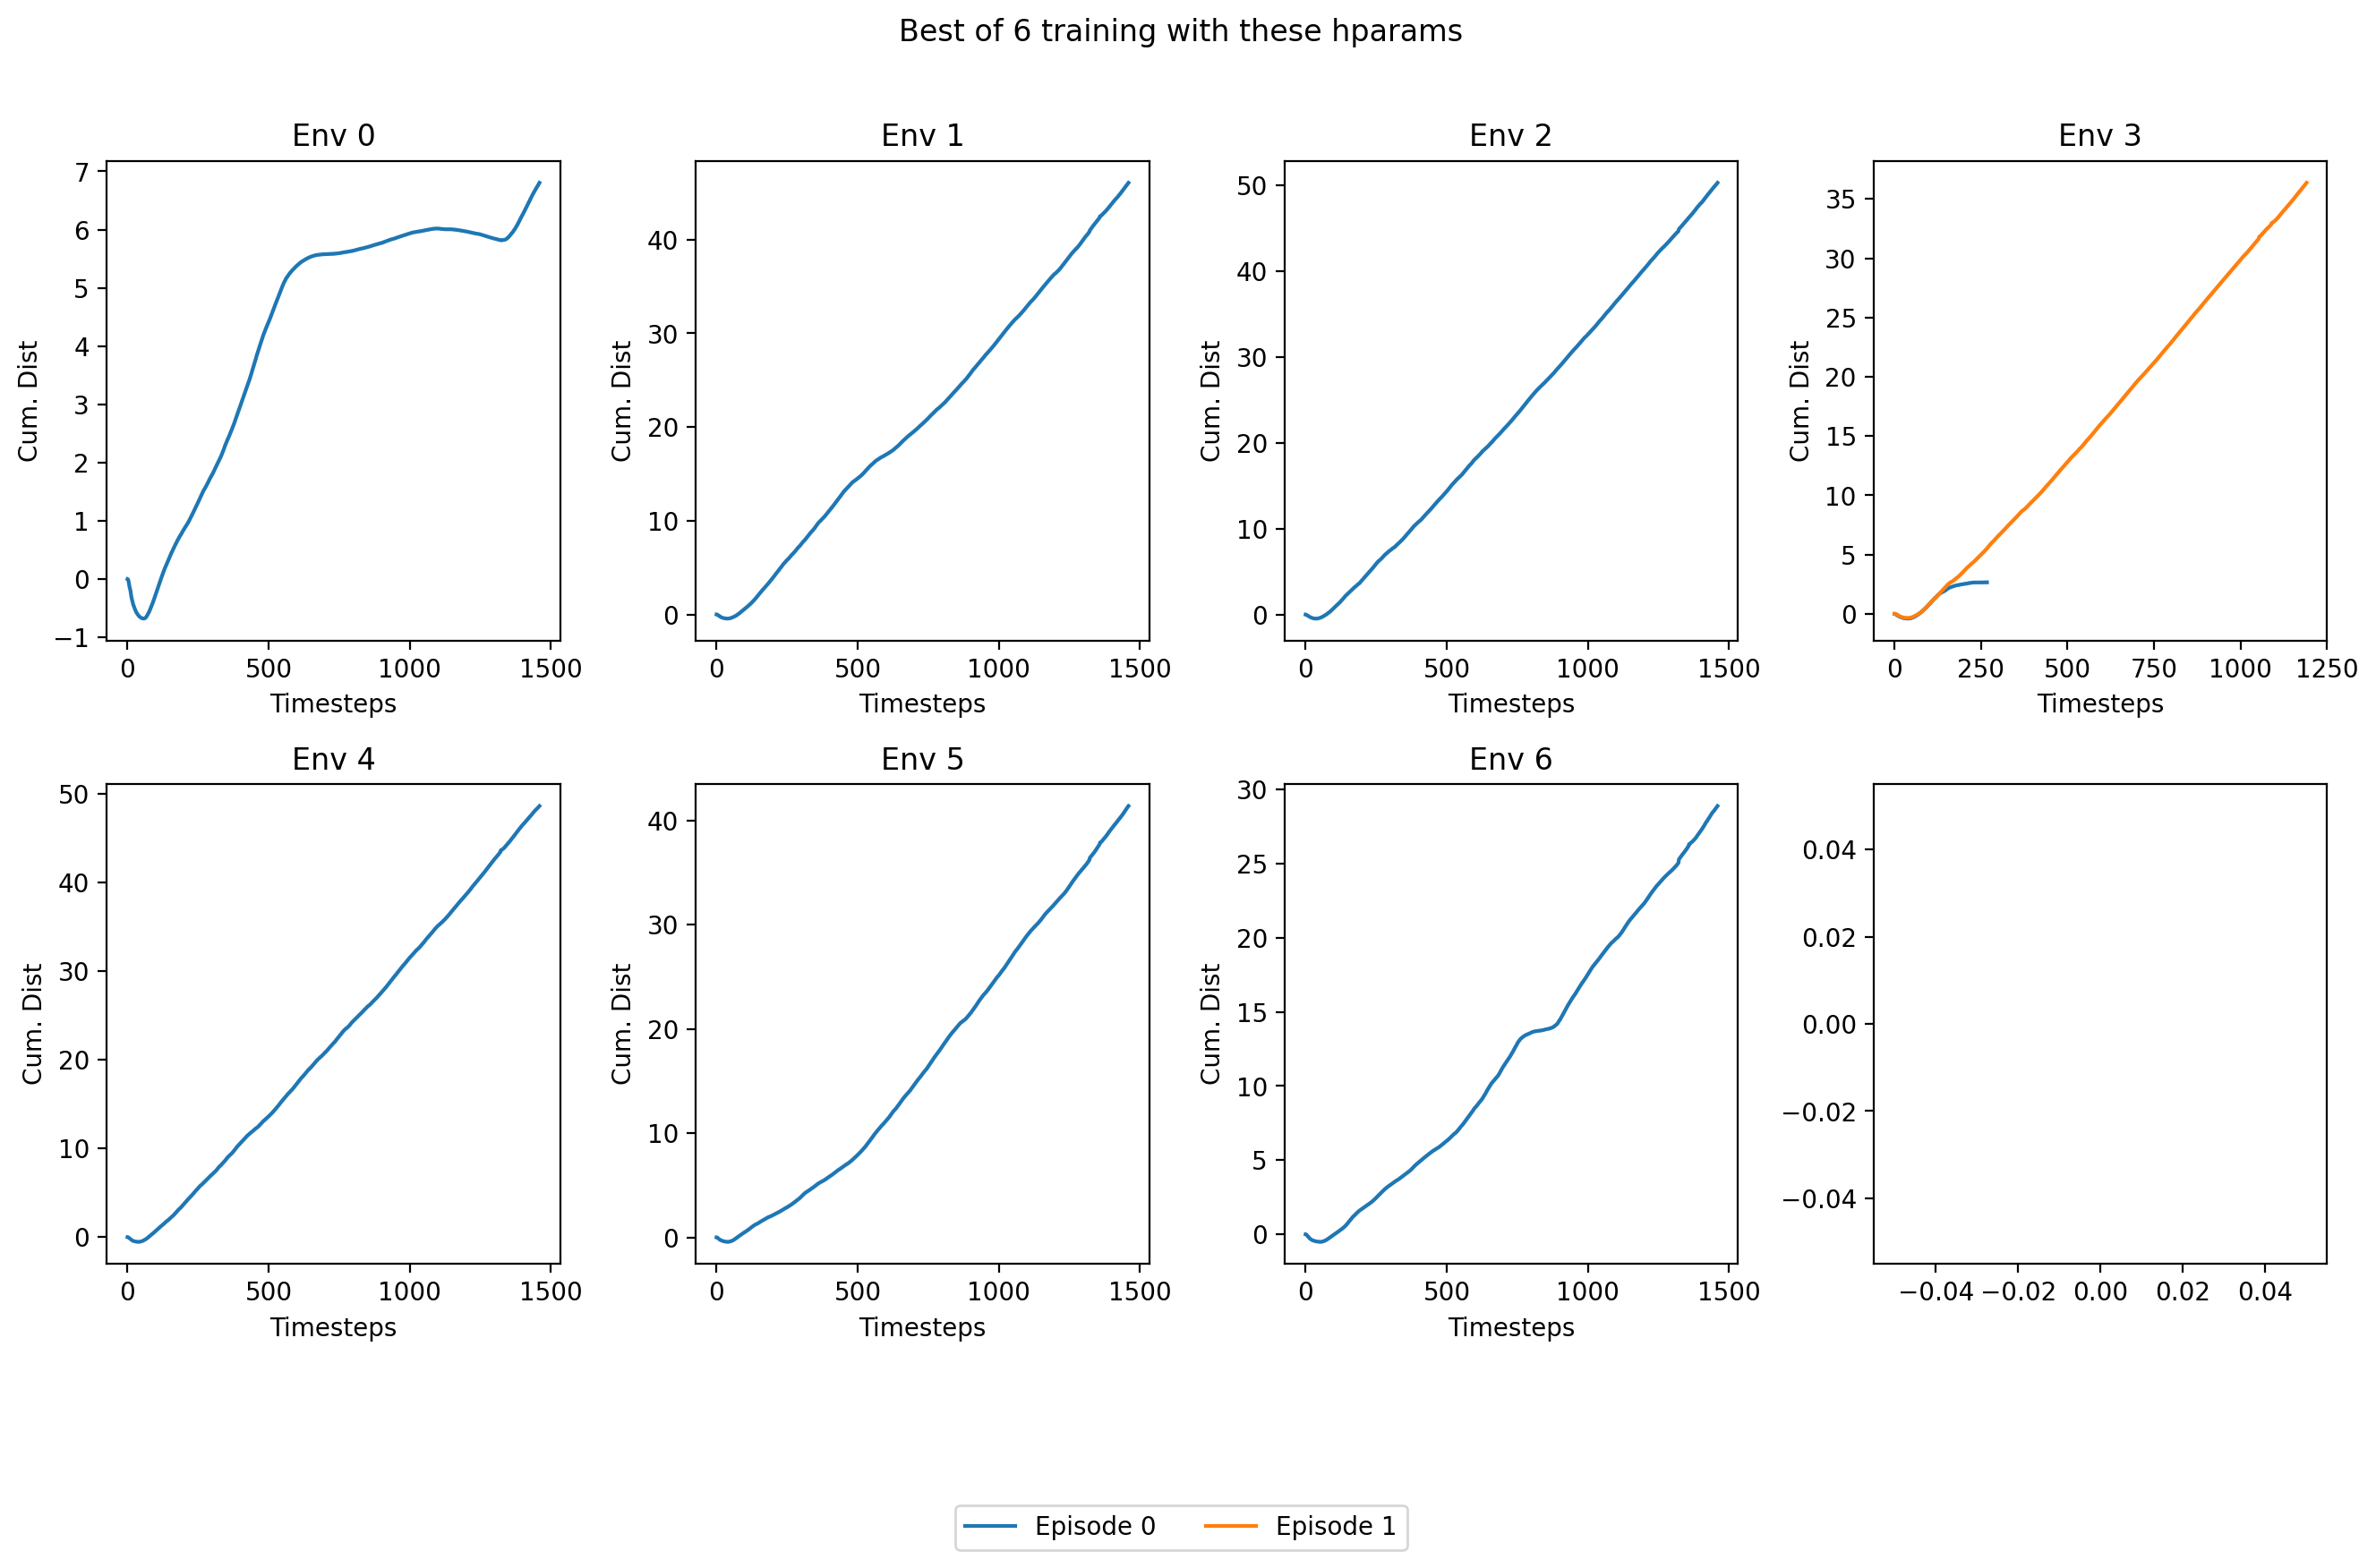

In [158]:
plot_gain_dist_by_episode('08-29-max-wind-v1-optuna-hparams-13-1', train=True, title='Best of 6 training with these hparams');

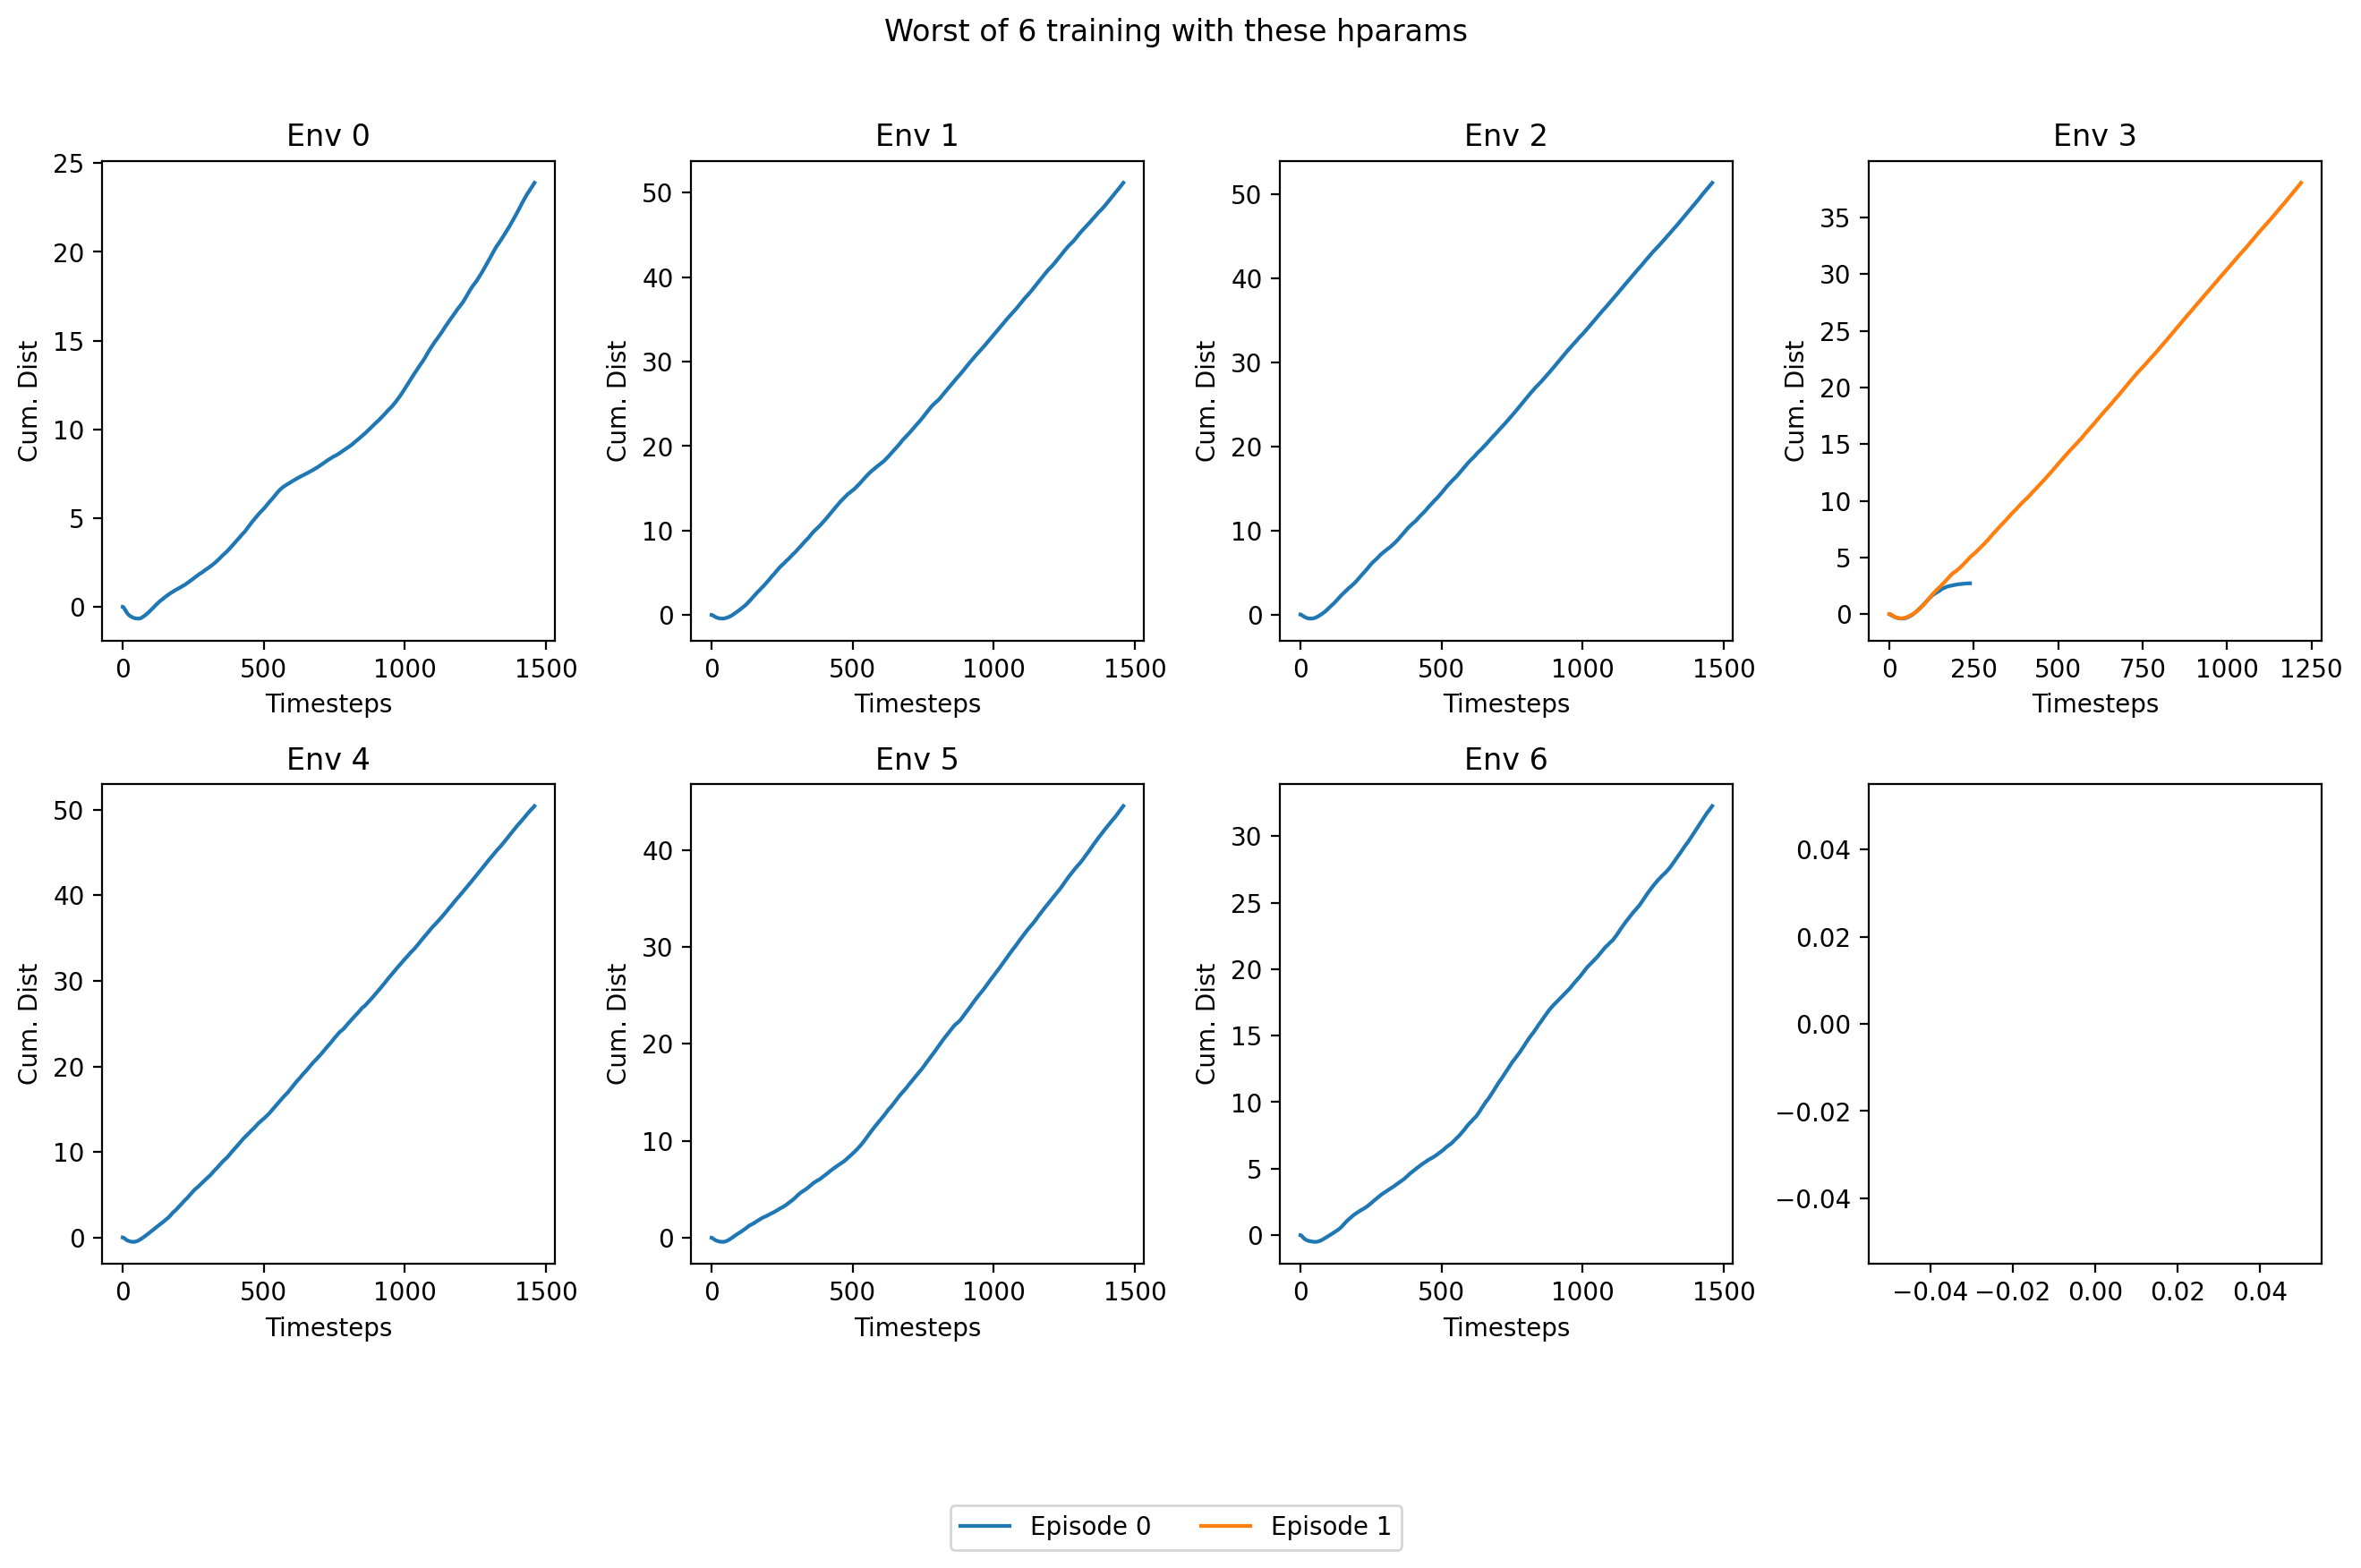

In [160]:
plot_gain_dist_by_episode('08-29-max-wind-v1-optuna-hparams-13-5', train=True, title='Worst of 6 training with these hparams');

# Scenario 0

## $T = 10.000$

In [ ]:
plot_gain_dist_by_episode('08-29-max-wind-v1-optuna-hparams-13-1', train=True, title='Best of 6 training with these hparams');

In [101]:
def plot_gain_dist_by_episode(name, title=None, train=False):
  folder = 'train' if train else 'eval'
  n_envs = len(glob(f'../runs/{name}/{folder}-*'))
  max_nb_episodes = max([len(glob(f'../runs/{name}/{folder}-{name}*{i}/*')) for i in range(n_envs)])

  n_rows = n_envs // 4 + 1
  n_cols = 4
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), dpi=200)

  def extract_label(filename):
    res = re.search(r'(\d)/(\d)/progress.csv', filename)
    return f'Env {res.group(1)}, Episode {res.group(2)}'

  for env_id in range(n_envs):
    axs_x = env_id // 4
    axs_y = env_id % 4
    ax = axs[axs_x, axs_y]
    ax.set_title(f'Env {env_id}')
    plot_metric(
      [f'{name}/{folder}-{name}*{env_id}/{i}' for i in range(max_nb_episodes)],
      metric='obs/cum_obs/gain_dist/0',
      y_label=f'Cum. Dist',
      ax=ax,
      hide_legend=True)
  for i in range(max_nb_episodes):
    axs[1, 3].plot([], [], label=f'Episode {i}')

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  fig.suptitle(title or name)
  fig.legend(loc='upper center',
              bbox_to_anchor=(0.5, -.05),
              ncol=4)